# Linear Frequency Modulated (LFM) Impulses and their Spectrum

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/olddudealex/rf-notebooks/blob/main/pulse-modulation.ipynb) [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/olddudealex/rf-notebooks/HEAD?labpath=pulse-modulation.ipynb)

It's very common to use the frequency modulated impulses in real radars, because it allows to increase the sensitivity of overall radar without changing the power.

First of all let's apply some math to get the right formula for linear frequency modulation.

## LFM Impulse Phase

So let's see how we can represent the full phase for our linear modulated signal.

If the phase(!) is linear:

$$
\theta(t)=\omega_0 t+\phi=2\pi f_0 t+\phi
$$

$$
\omega_0=\frac{d}{d t} \theta(t)
$$

And if the phase is quadrature:
$$
\theta(t)=2 \pi a t^2+2 \pi f_0 t+\phi
$$
where $\alpha$-some constant

In this case instant angular frequency and ordinary frequency will be:
$$
\omega_i(t)=\frac{d}{d t} \theta(t)=4 \pi \alpha t+2 \pi f_0 \quad
$$
$$
f_i(t)=2 \alpha t+f_0 \quad
$$

Taking into account the fact that it is linear modulated impulse with impulse length $T$ we get:
$$
k=2 \alpha=\tan\gamma=\frac{f_1-f_0}{T}
$$
$$
\omega_i(t)=\frac{d}{d t} \theta(t)=2 \pi\left(k t+f_0\right)
$$

So get back to phase:
$$
\begin{aligned}
\theta(t) & =\int \omega_i(t) d t=2 \pi \int\left(k t+f_0\right) d t= \\
& =2 \pi\left(k \frac{t^2}{2}+f_0 t\right)+\phi_0 \\
& =\frac{\Delta \omega}{T} \cdot \frac{t^2}{2}+\omega_0 t+\phi_0
\end{aligned}
$$
In future we will omit the initial phase $\phi_0$, because it has no impact on our results.

For our analysis we will use the FFT and we need to remember that this method has constraints and artifacts due to its discrete nature.

Ok, let's start with simple CW of 3GHz, the time units that we will have in discrete world set equal to 1ps.

FFT Bin Size=1.00Mhz


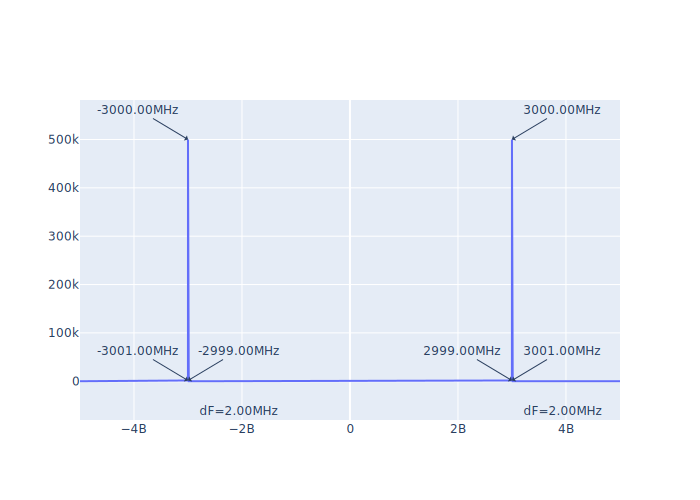

In [1]:
import plotly.io as pio

# The next line is a special one for auto-generation of static page version.
static_rendering = True
if static_rendering:
  pio.renderers.default = "svg"
elif 'google.colab' in str(get_ipython()):
  %cd /content
  !rm -rf rf-notebooks
  !git clone -q -s https://github.com/olddudealex/rf-notebooks/ rf-notebooks
  %cd rf-notebooks
  pio.renderers.default = "colab"
  print("The colab renderer is used")
else:
  pio.renderers.default = "plotly_mimetype+notebook"
  print("The notebook renderer is used")

import plot_data as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Initial parameters
f0 = 3 * (10**9)                # central freq of CW  3GHz
delta_f = 0                     # max - min freq diff 0MHz
tu = 1*10**(-12)                # time units (time resolution) 1ps
fs = 1/tu                       # sampling freq of simulation

L_sec = 1000 * (10**(-9))       # length of impulse   100ns
s_sec = 0 * (10**(-9))          # start of impulse    0ns
sim_dur = 1000 * (10**(-9))     # simulation duration 100ns
N = sim_dur / tu                # amount of samples
f_res = fs / N                  # FFT bin size

L = int(L_sec/tu)               # length of impulse in time units
s = int(s_sec/tu)               # start of impulse in time units
e = s + L                       # end of simulation

t = np.arange(0, sim_dur, tu)

print(f"FFT Bin Size={f_res/1000000:.2f}Mhz")

# create the CW impulse
rf = np.zeros(t.shape)
rf[s:e] = np.sin(2*np.pi*f0*t[s:e])

data = pd.PlotData(rf, fs)
data.trim_freq(-5 * 10**9, 5 * 10**9)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data.freq_domain_x, y=data.freq_domain, name='RF CW spectrum'),
              row=1, col=1)
pd.mark_peaks(fig, data, row=1, col=1)
pd.mark_bands(fig, data, row=1, col=1)

fig.update_layout(hovermode='x unified', height=500)
fig.show()

You can see that the FFT bin size is now equal to 1Mhz, this is our resolution that is defined by sampling frequency and amount of samples. Ok, with this resolution we can see that the spectrum is symmetrical (the signal is real) and the band is very narrow (it's only one frequency bin). What will be if we apply the modulation from -50 to 50 Mhz? Will be the spectrum bands be equal to 100Mhz? Let's try! Now and further I will hide the most of code to generate the signals, you always can find the details by inspecting other source files.

FFT Bin Size=1.00Mhz


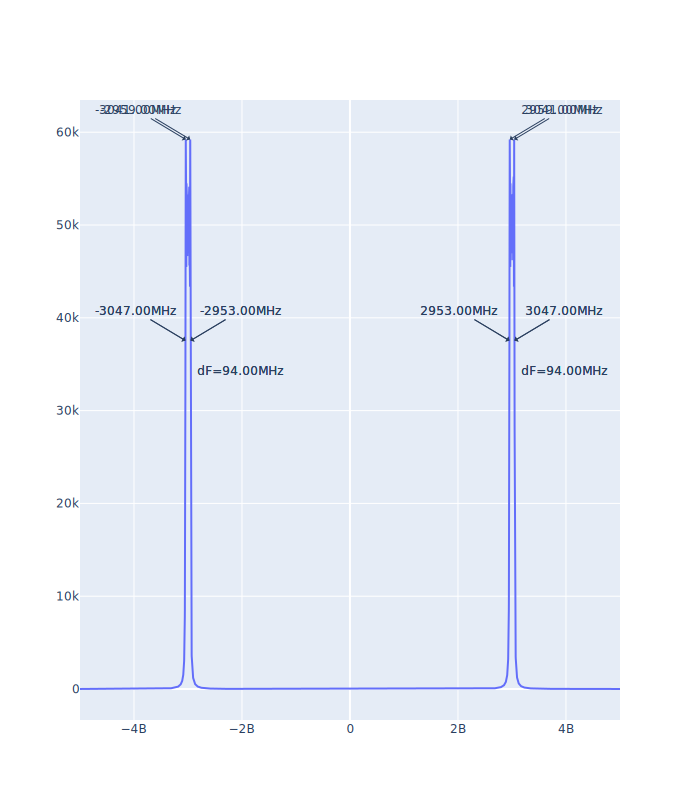

In [2]:
rf = pd.LfmSignal(f0=3*(10**9), delta_f=100*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=1000*(10**(-9)))

print(f"FFT Bin Size={rf.sig.f_res/1000000:.2f}Mhz")

data = pd.PlotData(rf.sig.data, rf.sig.fs)
data.trim_freq(-5 * 10 ** 9, 5 * 10 ** 9)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data.freq_domain_x,
                         y=data.freq_domain,
                         name='RF modulated impulse spectrum'),
              row=1, col=1)
peaks = data.freq_peaks
pd.mark_peaks(fig, data, row=1, col=1)
pd.mark_bands(fig, data, row=1, col=1)

fig.update_layout(hovermode='x unified', height=800)
fig.show()

Ok, the width of 94Mhz defined by -3dB level relative to maximum spikes is quite close to our expectation.

## LFM Impulse Spectrum
Our non-modulated real signal can be represented by a cos function:
$$
    s(t)=A\cos(2 \pi f_0 t)=A\cos(\omega_0 t)
$$
And in general case FM or PM signal will be:
$$
    s(t)=A\cos[\omega_0 t + \theta(t)]
$$
According to Euler formula:
$$
    cos(x)=Re(e^{jx})=\frac{e^{jx} - e^{-jx}}{2}
$$
These two terms correspond to two symmetrical with respect to zero peaks in frequency domain. You could think about this equation in a following manner. If we want to oscillate only along the Real axis on a complex circle, we have to sum two complex signals that are rotating synchronically in two opposite directions: clockwise and conterclockwise.  
Now, let's for simplicity focus only on one term further. So, after all we are looking at the signal:
$$
    s_1(t)=\frac{1}{2}e^{jx}=\frac{1}{2}exp[j\,x]
$$
And if we take into account our linear frequency modulated phase equation we get:
$$
    s_1(t)=\frac{1}{2}exp[j (\frac{\Delta \omega}{T} \cdot \frac{t^2}{2}+\omega_0 t)]
$$


The signal in Frequency domain could be get by Fourier transform:
$$
    S(\omega)=\int_{-\infty}^\infty s(t) \cdot exp(-j \omega t) \,dt
$$
$$
    S_1(\omega)= \frac{1}{2} \int_{-\infty}^\infty exp[j (\frac{\Delta \omega}{T} \cdot \frac{t^2}{2}+\omega_0 t)] \cdot exp(-j \omega t) \,dt
$$
$$
    S_1(\omega)=\frac{1}{2} \int_{-\infty}^\infty exp[j (\frac{\Delta \omega}{T} \cdot \frac{t^2}{2} + (\omega_0 - \omega) t))] \,dt
$$
This is quite cumbersome integral, but it has analytical solution with the help of Fresnel signals (please google it, if you are interested).  
The very final results after the solution of this signal is that the form of spectrum highly depends on the time-bandwidth product of the chirp $T\cdot \Delta f$.

## Time-Bandwidth Product Impact
Let's take several chirp impulses with different $T \cdot \Delta f$ parameters and see what is their spectrum.

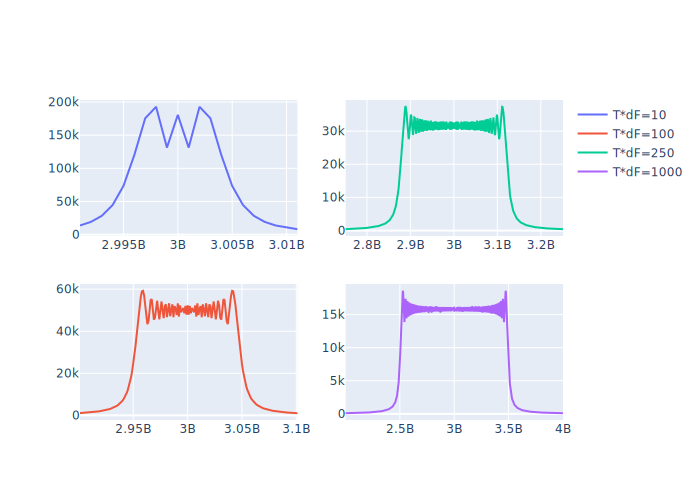

In [3]:
s1 = pd.LfmSignal(f0=3*(10**9), delta_f=10*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=1000*(10**(-9)))
s2 = pd.LfmSignal(f0=3*(10**9), delta_f=100*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=1000*(10**(-9)))
s3 = pd.LfmSignal(f0=3*(10**9), delta_f=250*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=1000*(10**(-9)))
s4 = pd.LfmSignal(f0=3*(10**9), delta_f=1000*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=1000*(10**(-9)))

data1 = pd.PlotData(s1.sig.data, s1.sig.fs)
data1.trim_freq(s1.f0 - s1.delta_f, s1.f0 + s1.delta_f)
data2 = pd.PlotData(s2.sig.data, s2.sig.fs)
data2.trim_freq(s2.f0 - s2.delta_f, s2.f0 + s2.delta_f)
data3 = pd.PlotData(s3.sig.data, s3.sig.fs)
data3.trim_freq(s3.f0 - s3.delta_f, s3.f0 + s3.delta_f)
data4 = pd.PlotData(s4.sig.data, s4.sig.fs)
data4.trim_freq(s4.f0 - s4.delta_f, s4.f0 + s4.delta_f)

fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=data1.freq_domain_x,
                         y=data1.freq_domain,
                         name='T*dF=10'), row=1, col=1)

fig.add_trace(go.Scatter(x=data2.freq_domain_x,
                         y=data2.freq_domain,
                         name='T*dF=100'), row=2, col=1)
fig.add_trace(go.Scatter(x=data3.freq_domain_x,
                         y=data3.freq_domain,
                         name='T*dF=250'), row=1, col=2)
fig.add_trace(go.Scatter(x=data4.freq_domain_x,
                         y=data4.freq_domain,
                         name='T*dF=1000'), row=2, col=2)

fig.update_layout(hovermode='x unified', height=500)
fig.show()

You can see now how the LFM signal spectrum depends on the product $T \cdot \Delta F$. The amount of energy that is kept outside of the min to max LFM band slightly varies. We can show it more explicit below:

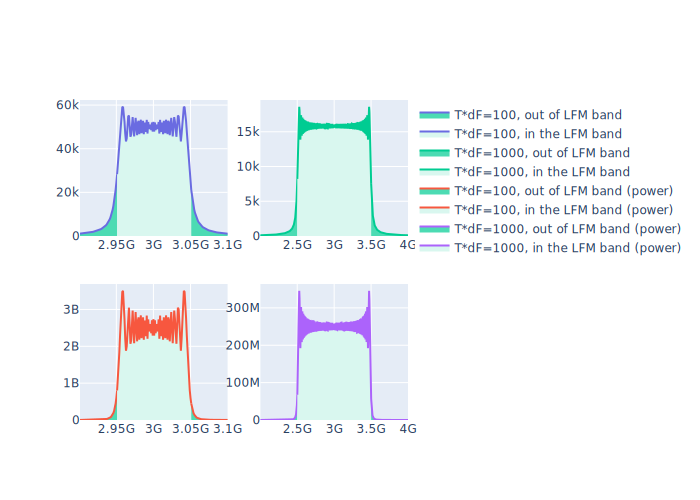

For T*dF=100 Pout/Pin=2.82%
For T*dF=1000 Pout/Pin=0.75%


In [4]:
import copy

s1 = pd.LfmSignal(f0=3*(10**9), delta_f=100*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=1000*(10**(-9)))
s2 = pd.LfmSignal(f0=3*(10**9), delta_f=1000*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=1000*(10**(-9)))

data1 = pd.PlotData(s1.sig.data, s1.sig.fs)
data1.trim_freq(s1.f0 - s1.delta_f, s1.f0 + s1.delta_f)
data1_1 = copy.deepcopy(data1)
data1_2 = copy.deepcopy(data1)
data1_3 = copy.deepcopy(data1)
data1_1.trim_freq(s1.f0 - s1.delta_f, s1.f1)
data1_2.trim_freq(s1.f1, s1.f2)
data1_3.trim_freq(s1.f2, s1.f0 + s1.delta_f)

data2 = pd.PlotData(s2.sig.data, s2.sig.fs)
data2.trim_freq(s2.f0 - s2.delta_f, s2.f0 + s2.delta_f)
data2_1 = copy.deepcopy(data2)
data2_2 = copy.deepcopy(data2)
data2_3 = copy.deepcopy(data2)
data2_1.trim_freq(s2.f0 - s2.delta_f, s2.f1)
data2_2.trim_freq(s2.f1, s2.f2)
data2_3.trim_freq(s2.f2, s2.f0 + s2.delta_f)

fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=data1_1.freq_domain_x,
                         y=data1_1.freq_domain,
                         line_color="#6A6BE1",
                         fill="tozeroy",
                         fillcolor="#4CDBB3",
                         name='T*dF=100, out of LFM band'), row=1, col=1)
fig.add_trace(go.Scatter(x=data1_2.freq_domain_x,
                         y=data1_2.freq_domain,
                         line_color="#6A6BE1",
                         fill="tozeroy",
                         fillcolor="#D9F7EF",
                         name='T*dF=100, in the LFM band'), row=1, col=1)
fig.add_trace(go.Scatter(x=data1_3.freq_domain_x,
                         y=data1_3.freq_domain,
                         line_color="#6A6BE1",
                         fill="tozeroy",
                         fillcolor="#4CDBB3",
                         showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=data2_1.freq_domain_x,
                         y=data2_1.freq_domain,
                         line_color="#00CC92",
                         fill="tozeroy",
                         fillcolor="#4CDBB3",
                         name='T*dF=1000, out of LFM band'), row=1, col=2)
fig.add_trace(go.Scatter(x=data2_2.freq_domain_x,
                         y=data2_2.freq_domain,
                         line_color="#00CC92",
                         fill="tozeroy",
                         fillcolor="#D9F7EF",
                         name='T*dF=1000, in the LFM band'), row=1, col=2)
fig.add_trace(go.Scatter(x=data2_3.freq_domain_x,
                         y=data2_3.freq_domain,
                         line_color="#00CC92",
                         fill="tozeroy",
                         fillcolor="#4CDBB3",
                         showlegend=False), row=1, col=2)

fig.add_trace(go.Scatter(x=data1_1.freq_domain_x,
                         y=np.power(data1_1.freq_domain, 2),
                         line_color="#F7573F",
                         fill="tozeroy",
                         fillcolor="#4CDBB3",
                         name='T*dF=100, out of LFM band (power)'), row=2, col=1)
fig.add_trace(go.Scatter(x=data1_2.freq_domain_x,
                         y=np.power(data1_2.freq_domain, 2),
                         line_color="#F7573F",
                         fill="tozeroy",
                         fillcolor="#D9F7EF",
                         name='T*dF=100, in the LFM band (power)'), row=2, col=1)
fig.add_trace(go.Scatter(x=data1_3.freq_domain_x,
                         y=np.power(data1_3.freq_domain, 2),
                         line_color="#F7573F",
                         fill="tozeroy",
                         fillcolor="#4CDBB3",
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=data2_1.freq_domain_x,
                         y=np.power(data2_1.freq_domain, 2),
                         line_color="#AC63FB",
                         fill="tozeroy",
                         fillcolor="#4CDBB3",
                         name='T*dF=1000, out of LFM band (power)'), row=2, col=2)
fig.add_trace(go.Scatter(x=data2_2.freq_domain_x,
                         y=np.power(data2_2.freq_domain, 2),
                         line_color="#AC63FB",
                         fill="tozeroy",
                         fillcolor="#D9F7EF",
                         name='T*dF=1000, in the LFM band (power)'), row=2, col=2)
fig.add_trace(go.Scatter(x=data2_3.freq_domain_x,
                         y=np.power(data2_3.freq_domain, 2),
                         line_color="#AC63FB",
                         fill="tozeroy",
                         fillcolor="#4CDBB3",
                         showlegend=False), row=2, col=2)

fig.update_layout(hovermode='x unified', height=500)
fig.update_xaxes(exponentformat="SI")
fig.show()

print(f"For T*dF=100 Pout/Pin="
      f"{100 * 2 * np.sum(np.power(data1_1.freq_domain, 2)) / np.sum(np.power(data1_2.freq_domain, 2)):.2f}%")

print(f"For T*dF=1000 Pout/Pin="
      f"{100 * 2 * np.sum(np.power(data2_1.freq_domain, 2)) / np.sum(np.power(data2_2.freq_domain, 2)):.2f}%")


The amount of energy inside the range between start and end frequencies of LFM (we can call it sweep range, this is green areas in the graphs) to outside (blue area) is different. The more the product $T \cdot \Delta f$ is, the more energy is kept inside the sweep range of LFM signal. But it's rather small amount of energy: for $T \cdot \Delta f = 100$ it's around 2.17%, for 1000 - less than 0.7%. These results match to the data from Wiki.